<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/EVA_session_2_5_Assignment/EVA_Session_2_5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F


In [18]:
!pip install GPUtil
import GPUtil 
GPUtil. getAvailable()
import torch 
use_cuda = torch. cuda. is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.843721216


In [19]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [20]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [22]:
example_data.shape

torch.Size([1000, 1, 28, 28])

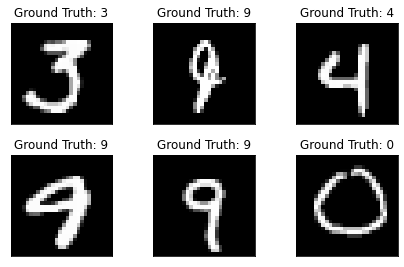

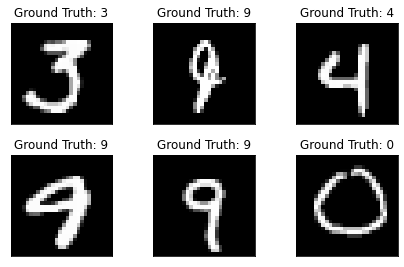

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # convolution layer with 32 of 3*3 kernels. 1*28*28 (1*30*30 with padding) - 32*28*28 - RF = 3*3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # convolution layer with 64 of 3*3 kernels.  32*28*28 (1*30*30 with padding) - 64*28*28 - RF = 5*5
        self.pool1 = nn.MaxPool2d(2, 2) # max pooling using a 2*2 kernel. 64*28*28 - 64*14*14 - RF = 10*10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # convolution layer with 128 of 3*3 kernels.  64*14*14 (64*16*16 with padding) - 128*14*14 - RF = 12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # convolution layer with 256 of 3*3 kernels.  128*14*14 (128*16*16 with padding) - 256*14*14 - RF = 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # max pooling using a 2*2 kernel. 256*14*14 - 256*7*7 - RF = 28*28
        self.conv5 = nn.Conv2d(256, 512, 3)# convolution layer with 512 of 3*3 kernels.  256*7*7 - 512*5*5 - RF = 30*30 (larger than image size?)
        self.conv6 = nn.Conv2d(512, 1024, 3)# convolution layer with 1024 of 3*3 kernels.  512*5*5 - 1024*3*3 - RF = 32*32 (larger than image size?)
        self.conv7 = nn.Conv2d(1024, 10, 3)# convolution layer with 10 of 3*3 kernels.  1024*3*3 - 10*1*1 - RF = 34*34 (larger than image size?)
    def forward(self, x): # module to implement the sequential neural network
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) # sequence of conv1 taking input imagge and output activated by rely, passes to conv2 activated by relu and pooled. 
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))) # sequence of taking above output and passing to conv3 and output activated by rely, passes to conv4 activated by relu and pooled. 
        x = F.relu(self.conv6(F.relu(self.conv5(x)))) # sequence of taking above output and passing to conv5 and output activated by relu. passes to conv6 and activated by relu.
        x = self.conv7(x)# sequence of taking above output and passing to conv7 and output activated by relu
        x = x.view(-1, 10) # flattening the output to 1-d (original vs. addition of lin)
        return F.log_softmax(x) # return the logged softmax of the 1-d

In [25]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [29]:
example_data[0].shape

torch.Size([1, 28, 28])

In [30]:
from torchsummary import summary

summary(network, example_data[0].shape)


RuntimeError: ignored

In [31]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [32]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

In [33]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [34]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-24-5dd3686f6f5e>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # return the logged softmax of the 1-d
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3022, Accuracy: 1090/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301951
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300333
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296467
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295267
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.283780
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.282754
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.282407
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.262009
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.253828
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.232238
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.216086
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.186129
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.826902
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.120453
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.931636
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.585250
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.417665
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.455837
Train Epoch: 1 [12160

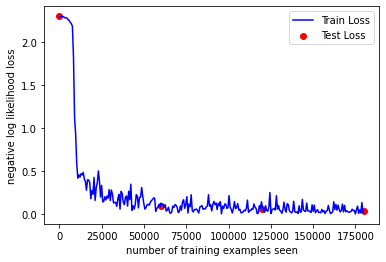

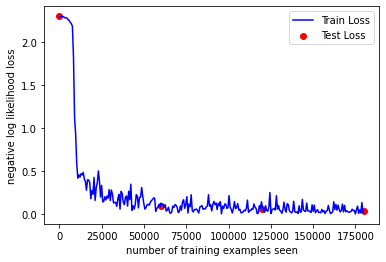

In [36]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig